# libcbm run of tutorial 2 from CBM-CFS3

In [1]:
import os, json
import pandas as pd

%matplotlib inline

Import the required packages from libcbm
 
    - sit_cbm_factory: a module for initializing the CBM model from the CBM Standard import tool format
    - cbm_simulator: simulates the sit dataset using the CBM model
    - libcbm.resources: gets files for tutorial 2 that are bundled in libcbm


In [9]:
from libcbm.input.sit import sit_cbm_factory
from libcbm.model.cbm import cbm_simulator
from libcbm.model.cbm.cbm_output import CBMOutput
from libcbm import resources
from libcbm.storage.backends import BackendType

## Setup
Load the standard import tool configuration at the specified path.  This configuration encompasses the data source for the various sit inputs (sit_inventory, sit_classifiers etc.) and also the relationships of classifiers, and disturbance types to the default CBM parameters.

In [10]:
config_path = os.path.join(
    resources.get_test_resources_dir(), "cbm3_tutorial2", "sit_config.json"
)
sit = sit_cbm_factory.load_sit(config_path)

Initialize and validate the inventory in the sit dataset

In [11]:
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)

Create storage for CBM simulation results.  This is a built in method, and it is not mandatory since it is possible to interact with the simulation dataframes directly as well.

In [12]:
cbm_output = CBMOutput(
    classifier_map=sit.classifier_value_names,
    disturbance_type_map=sit.disturbance_name_map,
)

## Simulation
The following line of code spins up the CBM inventory and runs it through 100 timesteps. 

In [13]:
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(
        sit, cbm
    )
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(
        cbm,
        n_steps=200,
        classifiers=classifiers,
        inventory=inventory,
        pre_dynamics_func=rule_based_processor.pre_dynamics_func,
        reporting_func=cbm_output.append_simulation_result,
        backend_type=BackendType.numpy,
    )

## Pool Results

In [17]:
pi = cbm_output.classifiers.to_pandas().merge(
    cbm_output.pools.to_pandas(),
    left_on=["identifier", "timestep"],
    right_on=["identifier", "timestep"],
)

In [18]:
pi.head()

,identifier,timestep,Working_Species_Or_Leading_Species,Site_Quality,Density_Class,Working_Status,Input,SoftwoodMerch,SoftwoodFoliage,SoftwoodOther,...,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products
0,1,0,B,G,D,W,200.0,0.000000,0.000000,0.0,...,10529.242115,5568.605479,1544.809522,0.0,0.0,690032.809697,631.259013,5681.261733,0.0,0.0
1,2,0,B,G,D,W,100.0,0.003124,0.376897,0.0,...,5273.531854,2666.157167,666.417417,0.0,0.0,345255.294728,315.629506,2840.630866,0.0,0.0
2,3,0,B,G,D,W,100.0,0.030782,1.867345,0.0,...,5278.708266,2553.024910,574.973378,0.0,0.0,345471.445778,315.629506,2840.630866,0.0,0.0
3,4,0,B,G,D,W,100.0,0.117354,4.744316,0.0,...,5281.125622,2444.693447,496.077048,0.0,0.0,345669.654559,315.629506,2840.630866,0.0,0.0
4,5,0,B,G,D,W,100.0,0.303283,9.168135,0.0,...,5281.488695,2340.959458,428.006664,0.0,0.0,345853.464520,315.629506,2840.630866,0.0,0.0


<AxesSubplot:xlabel='Year'>

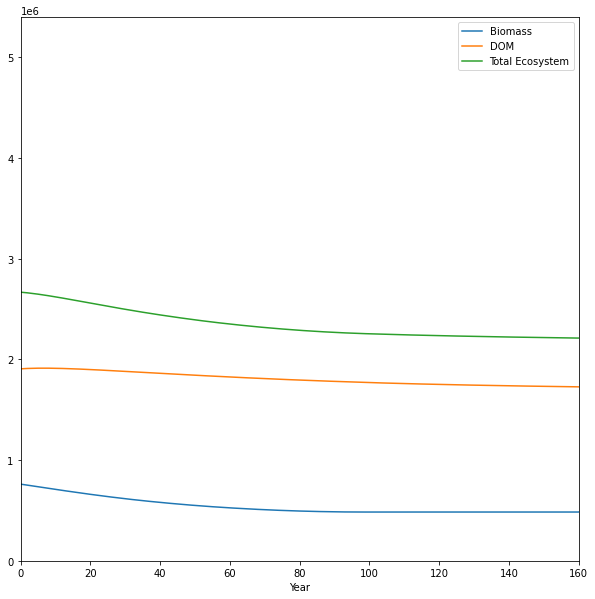

In [19]:
biomass_pools = [
    "SoftwoodMerch",
    "SoftwoodFoliage",
    "SoftwoodOther",
    "SoftwoodCoarseRoots",
    "SoftwoodFineRoots",
    "HardwoodMerch",
    "HardwoodFoliage",
    "HardwoodOther",
    "HardwoodCoarseRoots",
    "HardwoodFineRoots",
]

dom_pools = [
    "AboveGroundVeryFastSoil",
    "BelowGroundVeryFastSoil",
    "AboveGroundFastSoil",
    "BelowGroundFastSoil",
    "MediumSoil",
    "AboveGroundSlowSoil",
    "BelowGroundSlowSoil",
    "SoftwoodStemSnag",
    "SoftwoodBranchSnag",
    "HardwoodStemSnag",
    "HardwoodBranchSnag",
]

biomass_result = pi[["timestep"] + biomass_pools]
dom_result = pi[["timestep"] + dom_pools]
total_eco_result = pi[["timestep"] + biomass_pools + dom_pools]

annual_carbon_stocks = pd.DataFrame(
    {
        "Year": pi["timestep"],
        "Biomass": pi[biomass_pools].sum(axis=1),
        "DOM": pi[dom_pools].sum(axis=1),
        "Total Ecosystem": pi[biomass_pools + dom_pools].sum(axis=1),
    }
)

annual_carbon_stocks.groupby("Year").sum().plot(
    figsize=(10, 10), xlim=(0, 160), ylim=(0, 5.4e6)
)

## State Variable Results

In [23]:
si = cbm_output.state.to_pandas()

In [24]:
si.head()

,identifier,timestep,last_disturbance_type,time_since_last_disturbance,time_since_land_class_change,growth_enabled,enabled,land_class,age,growth_multiplier,regeneration_delay
0,1,0,N,0,-1,1,1,0,0,1.0,0
1,2,0,N,1,-1,1,1,0,1,1.0,0
2,3,0,N,2,-1,1,1,0,2,1.0,0
3,4,0,N,3,-1,1,1,0,3,1.0,0
4,5,0,N,4,-1,1,1,0,4,1.0,0


<AxesSubplot:xlabel='timestep'>

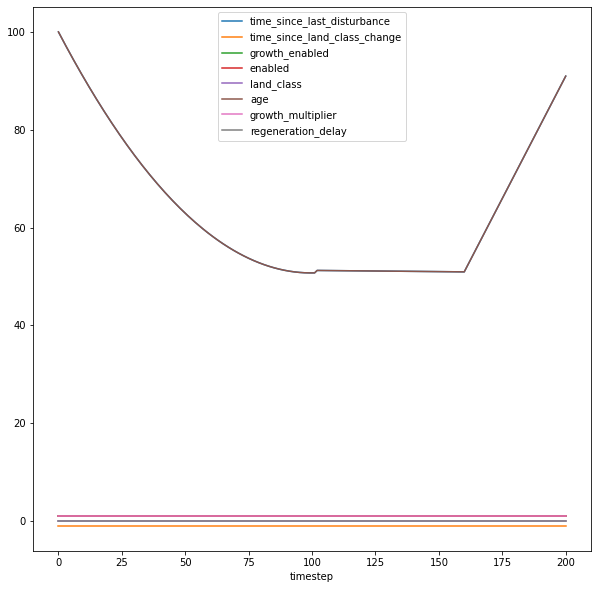

In [25]:
state_variables = [
    "timestep",
    "time_since_last_disturbance",
    "time_since_land_class_change",
    "growth_enabled",
    "enabled",
    "land_class",
    "age",
    "growth_multiplier",
    "regeneration_delay",
]
si[state_variables].groupby("timestep").mean().plot(figsize=(10, 10))

## Flux Indicators

In [30]:
fi = cbm_output.flux.to_pandas()

In [31]:
fi.head()

,identifier,timestep,DisturbanceCO2Production,DisturbanceCH4Production,DisturbanceCOProduction,DisturbanceBioCO2Emission,DisturbanceBioCH4Emission,DisturbanceBioCOEmission,DecayDOMCO2Emission,DisturbanceSoftProduction,...,DisturbanceVFastBGToAir,DisturbanceFastAGToAir,DisturbanceFastBGToAir,DisturbanceMediumToAir,DisturbanceSlowAGToAir,DisturbanceSlowBGToAir,DisturbanceSWStemSnagToAir,DisturbanceSWBranchSnagToAir,DisturbanceHWStemSnagToAir,DisturbanceHWBranchSnagToAir
0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
annual_process_fluxes = [
    "DecayDOMCO2Emission",
    "DeltaBiomass_AG",
    "DeltaBiomass_BG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
    "DecayVFastAGToAir",
    "DecayVFastBGToAir",
    "DecayFastAGToAir",
    "DecayFastBGToAir",
    "DecayMediumToAir",
    "DecaySlowAGToAir",
    "DecaySlowBGToAir",
    "DecaySWStemSnagToAir",
    "DecaySWBranchSnagToAir",
    "DecayHWStemSnagToAir",
    "DecayHWBranchSnagToAir",
]

<AxesSubplot:xlabel='timestep'>

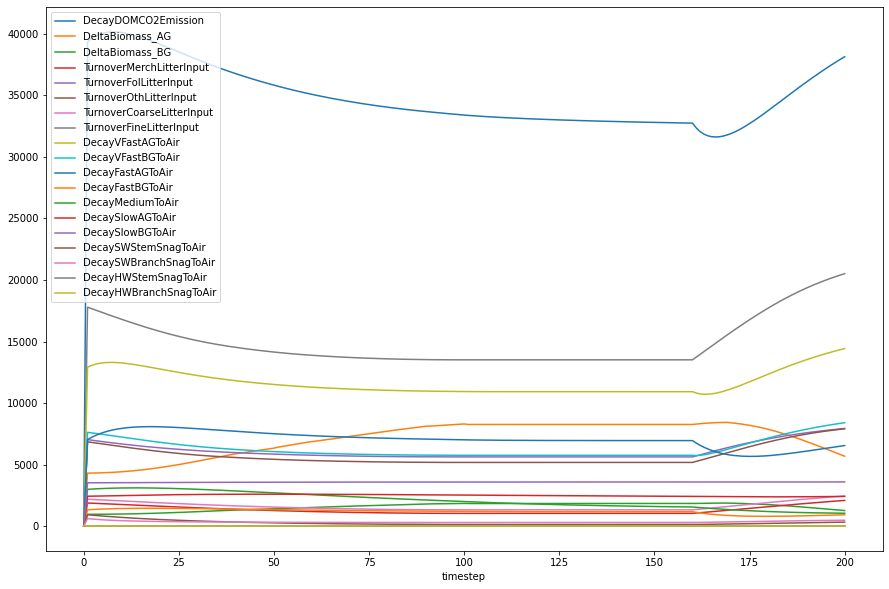

In [33]:
fi[["timestep"] + annual_process_fluxes].groupby("timestep").sum().plot(
    figsize=(15, 10)
)

## Appendix

### SIT source data

In [34]:
sit.sit_data.age_classes

,name,class_size,start_year,end_year
0,AGEID0,0,0,0
1,AGEID1,10,1,10
2,AGEID2,10,11,20
3,AGEID3,10,21,30
4,AGEID4,10,31,40
5,AGEID5,10,41,50
6,AGEID6,10,51,60
7,AGEID7,10,61,70
8,AGEID8,10,71,80
9,AGEID9,10,81,90


In [35]:
sit.sit_data.inventory

,Working_Species_Or_Leading_Species,Site_Quality,Density_Class,Working_Status,age,area,delay,land_class,historical_disturbance_type,last_pass_disturbance_type
0,BF,GOOD,D1,W,0,200,0,0,DISTID1,DISTID1
1,BF,GOOD,D1,W,1,100,0,0,DISTID1,DISTID1
2,BF,GOOD,D1,W,2,100,0,0,DISTID1,DISTID1
3,BF,GOOD,D1,W,3,100,0,0,DISTID1,DISTID1
4,BF,GOOD,D1,W,4,100,0,0,DISTID1,DISTID1
...,...,...,...,...,...,...,...,...,...,...
196,BF,GOOD,D1,W,196,100,0,0,DISTID1,DISTID1
197,BF,GOOD,D1,W,197,100,0,0,DISTID1,DISTID1
198,BF,GOOD,D1,W,198,100,0,0,DISTID1,DISTID1
199,BF,GOOD,D1,W,199,100,0,0,DISTID1,DISTID1


In [36]:
sit.sit_data.classifiers

,id,name
0,1,Working_Species_Or_Leading_Species
1,2,Site_Quality
2,3,Density_Class
3,4,Working_Status


In [37]:
sit.sit_data.classifier_values

,classifier_id,name,description
1,1,BF,Balsam Fir
2,1,BS,Black Spruce
3,1,JL,Western Larch
4,1,JP,Jack Pine
5,1,OS,Other Spruce
6,1,RP,Red Pine
7,1,SH,Unspecified Softwood
8,1,LT,Larch
9,1,WS,White Spruce
11,2,GOOD,Good


In [38]:
sit.sit_data.disturbance_types

,sit_disturbance_type_id,id,name
0,1,DISTID1,Natural forest fire
1,2,DISTID2,Senescence
2,3,DISTID3,Mountain pine beetle infestation
3,4,DISTID4,ClearCut Harvesting


In [41]:
sit.sit_data.disturbance_events

,Working_Species_Or_Leading_Species,Site_Quality,Density_Class,Working_Status,min_age,max_age,MinYearsSinceDist,MaxYearsSinceDist,LastDistTypeID,MinTotBiomassC,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,time_step
0,BF,GOOD,D1,W,80,200,-1,-1,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,200,DISTID4,1
1,BF,GOOD,D1,W,80,200,-1,-1,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,200,DISTID4,2
2,BF,GOOD,D1,W,80,200,-1,-1,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,200,DISTID4,3
3,BF,GOOD,D1,W,80,200,-1,-1,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,200,DISTID4,4
4,BF,GOOD,D1,W,80,200,-1,-1,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,200,DISTID4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,BF,GOOD,D1,W,80,200,-1,-1,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,200,DISTID4,156
156,BF,GOOD,D1,W,80,200,-1,-1,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,200,DISTID4,157
157,BF,GOOD,D1,W,80,200,-1,-1,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,200,DISTID4,158
158,BF,GOOD,D1,W,80,200,-1,-1,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,200,DISTID4,159


In [39]:
sit.sit_data.yield_table

,Working_Species_Or_Leading_Species,Site_Quality,Density_Class,Working_Status,leading_species,v0,v1,v2,v3,v4,...,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20
0,BF,GOOD,D1,W,29,0,0,0,8,20,...,112,113,113,113,113,113,113,113,113,113


In [40]:
print(json.dumps(sit.config, indent=4, sort_keys=True))

{
    "import_config": {
        "age_classes": {
            "params": {
                "path": "age_classes.csv"
            },
            "type": "csv"
        },
        "classifiers": {
            "params": {
                "path": "classifiers.csv"
            },
            "type": "csv"
        },
        "disturbance_types": {
            "params": {
                "path": "disturbance_types.csv"
            },
            "type": "csv"
        },
        "events": {
            "params": {
                "path": "disturbance_events.csv"
            },
            "type": "csv"
        },
        "inventory": {
            "params": {
                "path": "inventory.csv"
            },
            "type": "csv"
        },
        "transitions": {
            "params": {
                "path": "transition_rules.csv"
            },
            "type": "csv"
        },
        "yield": {
            "params": {
                "path": "growth_and_yield.csv"
            